In [1]:
from qiskit.circuit import *
import numpy as np
from qiskit_aer import StatevectorSimulator
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.visualization.state_visualization import _bloch_multivector_data
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.add_control import add_control
from qiskit import transpile

import functools

In [2]:
def U_omega_oracle(f: list[bool]) -> QuantumCircuit:
    num_qubits = int(np.log2(len(f)))
    num_1 = f.count(True)
    omega_state = np.array([[1./np.sqrt(num_1)+0j] if _ else [0j] for _ in f])
    I = np.array([[1+0j if j == i else 0j for j in range(len(omega_state))] for i in range(len(omega_state))],dtype=complex)
    s0_gate = UnitaryGate(I - 2*omega_state @ omega_state.T,num_qubits=num_qubits)
    s0_gate.name='Uw'
    return s0_gate


def U_s_oracle(f: list[bool]) -> QuantumCircuit:
    qc = QuantumCircuit(np.log2(len(f)))
    qc.h(qc.qubits)
    # zeros_n = np.array(functools.reduce(np.kron, [[[1.+0j],[0j]] for _ in range(qc.num_qubits)]))
    # I = np.array([[1+0j if j == i else 0j for j in range(len(zeros_n))] for i in  range(len(zeros_n))],dtype=complex)
    # s0_gate = UnitaryGate(2*zeros_n @ zeros_n.T - I,label='(2|0><0|-I)')
    # print(s0_gate.to_matrix())
    # qc.append(s0_gate,qc.qubits,copy=False)
    qc.x(qc.qubits)
    qc.h(qc.qubits[0])
    qc.mcx(qc.qubits[1:],qc.qubits[0])
    qc.h(qc.qubits[0])
    qc.x(qc.qubits)
    qc.h(qc.qubits)
    qc.name='Us'
    return qc

def grover(f: list[bool]):
    num_qubits= np.log2(len(f))
    quantum_bits = QuantumRegister(num_qubits,name='q')
    classic_bits = ClassicalRegister(num_qubits,name='c')
    qc = QuantumCircuit(quantum_bits, classic_bits)
    qc.h(qc.qubits)

    omega_qc = U_omega_oracle(f)
    s_qc = U_s_oracle(f)

    r = int(np.floor(np.pi*(np.sqrt(2**num_qubits))/4))
    qc.barrier()
    for _ in range(r):
        omega_qc_i = omega_qc.copy(omega_qc.name+f"{_}")
        s_qc_i = s_qc.copy(s_qc.name+f"{_}")
        qc.append(omega_qc_i,qc.qubits,copy=False)
        qc.append(s_qc_i,qc.qubits,copy=False)
        qc.barrier()
    qc.measure(quantum_bits[::-1], classic_bits[::-1])
    return qc
    # oracle

In [3]:
n=6
f = [0 for i in range(2**n)]
f[5]=1
f[10]=1
print(f)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


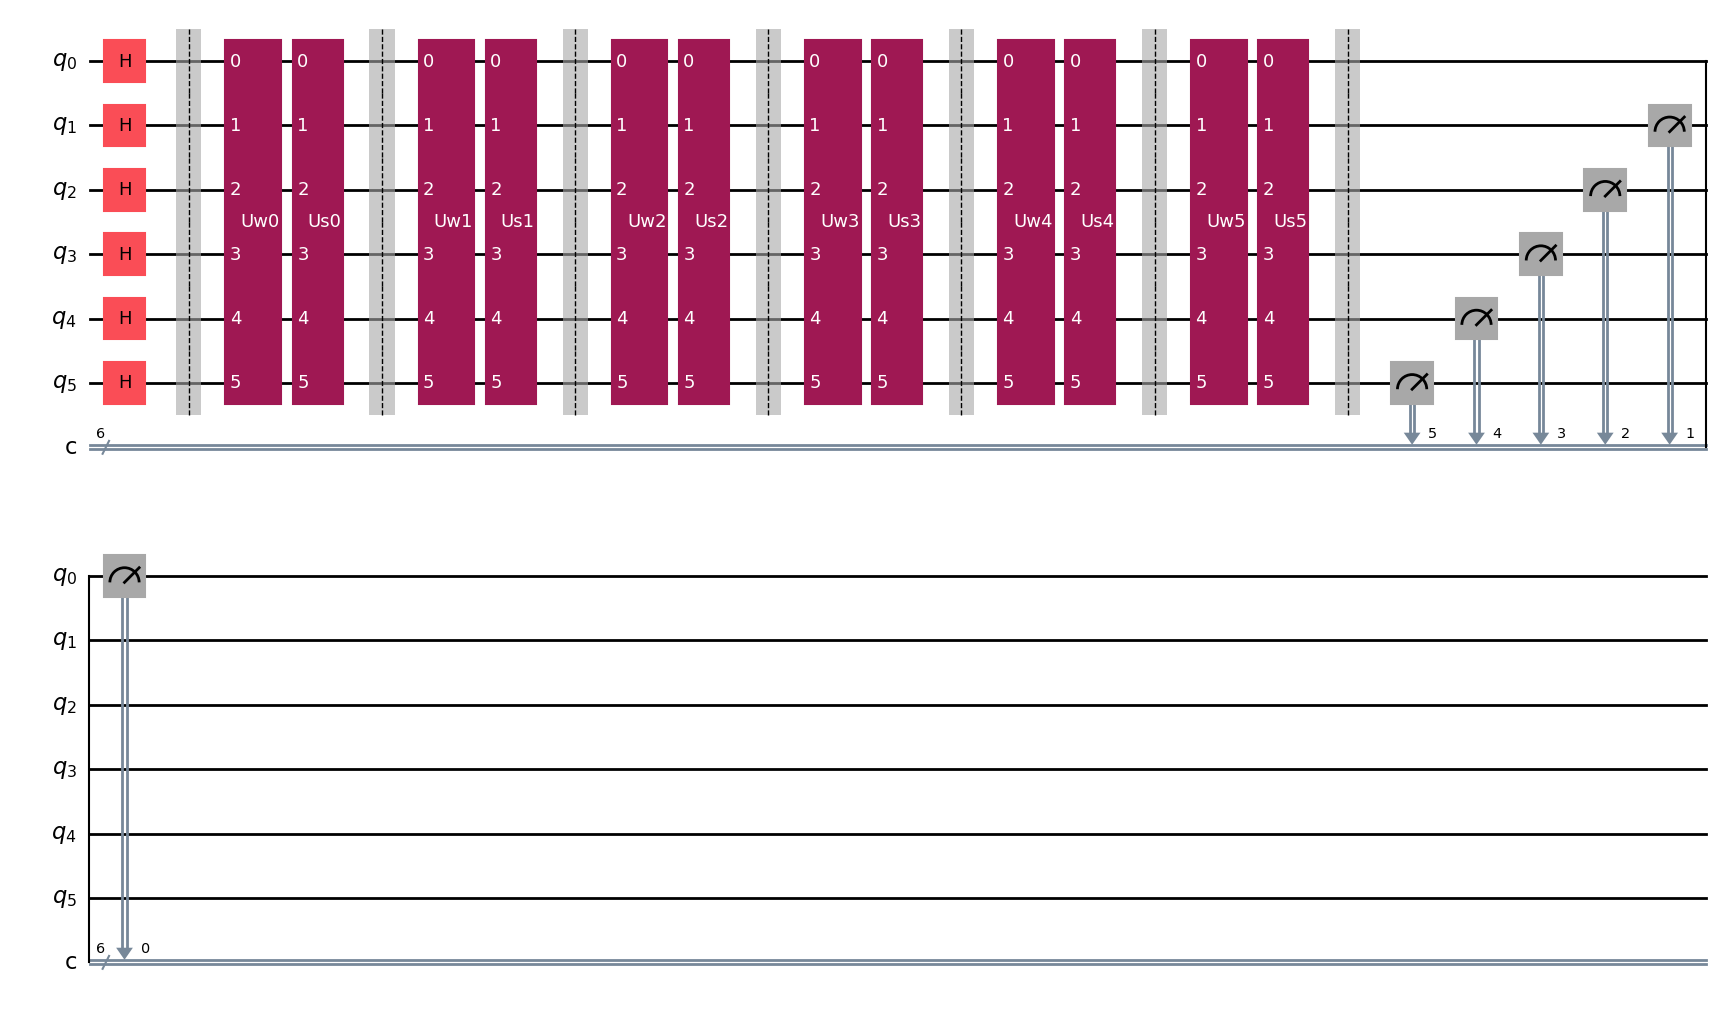

In [4]:
grover_qc=grover(f)
grover_qc.draw('mpl')

In [5]:
from qiskit.visualization import plot_histogram
backend = StatevectorSimulator()
shots=1000
job = backend.run(transpile(grover_qc,backend),memory=True,shots=shots)
result =  job.result()
print(result.get_counts())

{'011000': 6, '100001': 10, '001010': 290, '111111': 7, '110010': 5, '101110': 12, '000101': 262, '111110': 4, '001011': 12, '100010': 8, '011110': 5, '101000': 9, '110100': 12, '000011': 6, '101100': 17, '111100': 8, '100100': 8, '001101': 8, '100101': 7, '001110': 5, '111011': 6, '000010': 4, '110101': 5, '101011': 8, '001111': 11, '111010': 7, '100110': 4, '101111': 8, '110001': 6, '000110': 7, '010011': 7, '111001': 11, '100111': 8, '010111': 10, '101010': 6, '110110': 3, '000001': 6, '010000': 7, '110000': 4, '000111': 4, '010100': 6, '010010': 10, '111101': 10, '001100': 3, '100011': 7, '101101': 3, '110011': 13, '000100': 9, '001001': 7, '001000': 6, '101001': 6, '000000': 6, '110111': 6, '011011': 4, '011010': 9, '011001': 5, '011101': 11, '011100': 5, '010110': 6, '010101': 10, '111000': 3, '010001': 5, '011111': 9, '100000': 8}


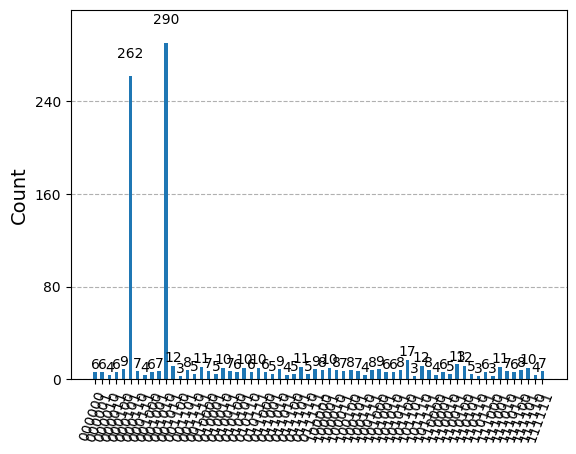

In [6]:
plot_histogram(result.get_counts())